#### Prepare a prediction model for profit of 50_startups data. Do transformations for getting better predictions of profit and make a table containing $R^2$ value for each prepared model.

<table>
<tr>
    <th>Variables</th>
    <th>Discription</th>
</tr>

<tr>
    <td>R&D Spend</td>
    <td>Research and develop spend in the past few years </td>
</tr>

<tr>
    <td>Administration</td>
    <td>spend on administraion in past few years</td>
</tr>

<tr>
    <td>Marketing spend</td>
    <td>Spend on marketing in past few years</td>
</tr>

<tr>
    <td>States</td>
    <td>States from which data is collected</td>
</tr>

<tr>
    <td>Profit</td>
    <td>Profit of each state in past few years</td>
</tr>
</table>

In [38]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

## Load data and get insight

In [39]:
data =  pd.read_csv('50_Startups.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## EDA

In [40]:
data.shape

(50, 5)

<AxesSubplot: >

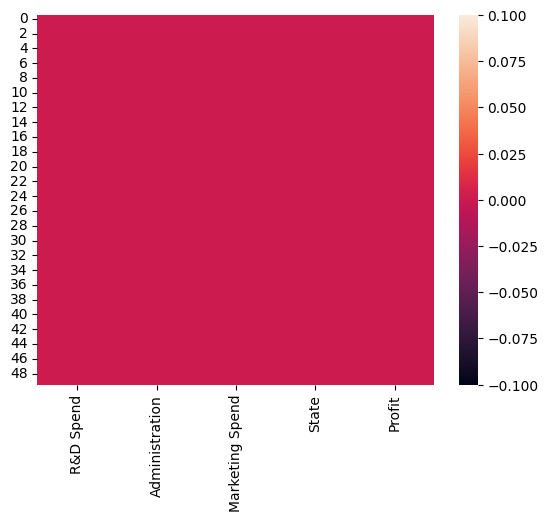

In [41]:
# check for any null values
sns.heatmap(data.isnull())
# no null value

In [42]:
# check for datatpe and null values
data.info()
# there is no null values and 'State' column is object type others are decimal.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [43]:
# Checking unique values of state column
print("number of unique state: ",data['State'].nunique())
print("Name of unique state: ",data['State'].unique())
print(data['State'].value_counts())

number of unique state:  3
Name of unique state:  ['New York' 'California' 'Florida']
New York      17
California    17
Florida       16
Name: State, dtype: int64


## data preprocessing

In [44]:
# drop unnecessary column and rename columns
data.drop(['State'],axis=1,inplace=True)
data.rename(columns = {'R&D Spend':'RD', 'Marketing Spend':'MS', 'Administration':'AD'}, inplace = True)

In [45]:
# check statistics of numerical column
data.describe()

,RD,AD,MS,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


<AxesSubplot: xlabel='Profit'>

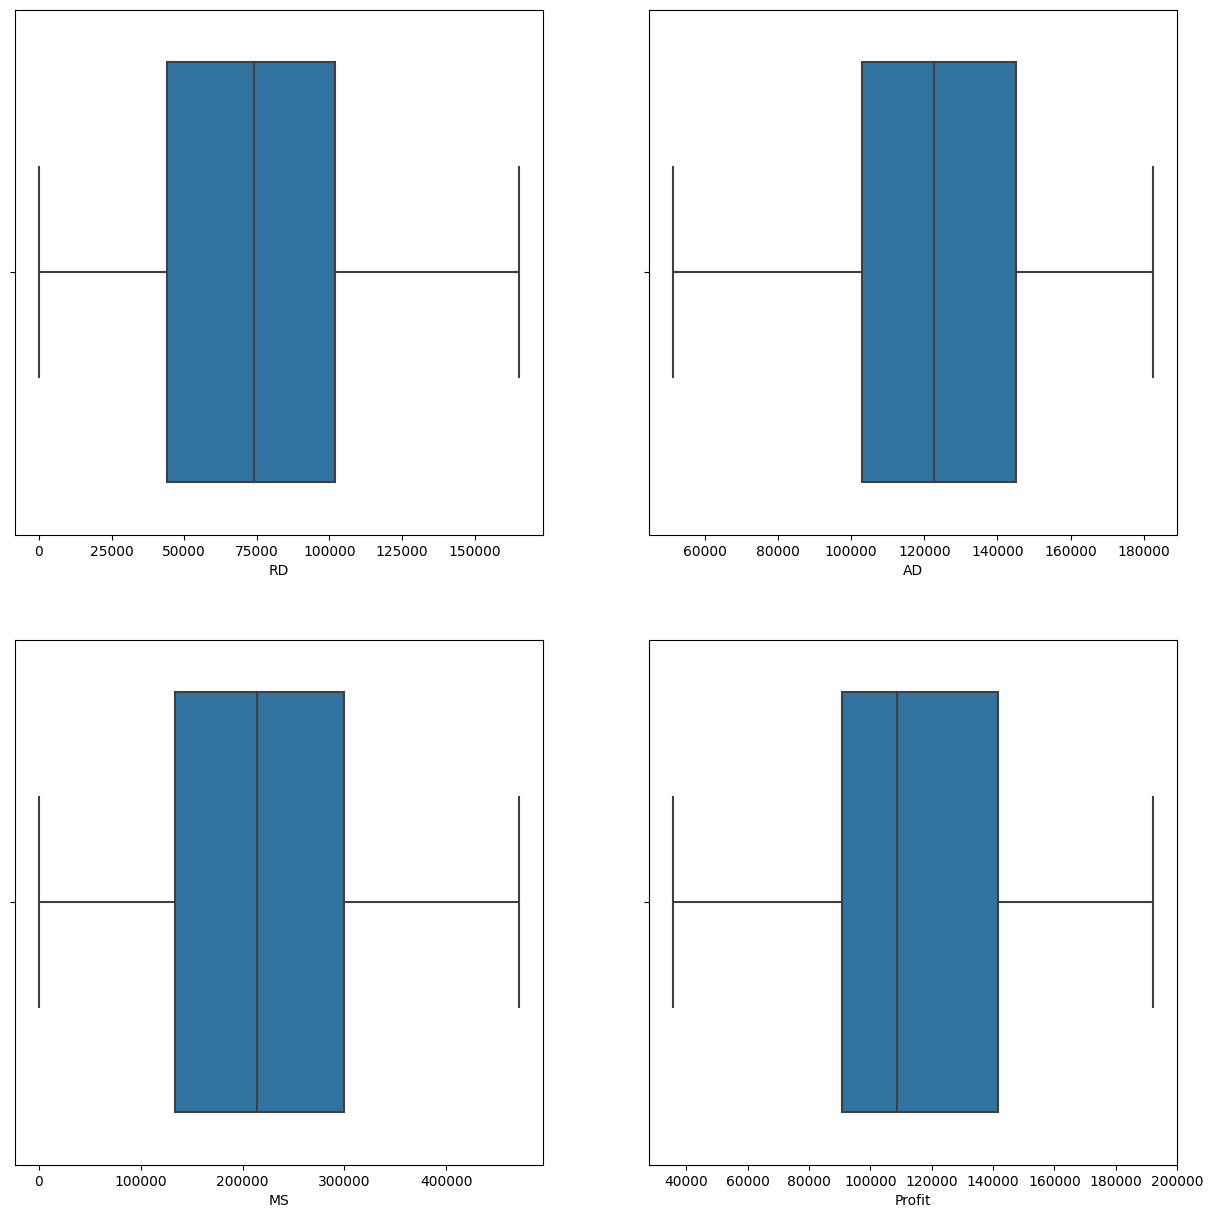

In [48]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.boxplot(data=data, x= 'RD')

plt.subplot(2,2,2)
sns.boxplot(data=data, x= 'AD')

plt.subplot(2,2,3)
sns.boxplot(data=data, x= 'MS')

plt.subplot(2,2,4)
sns.boxplot(data=data, x= 'Profit')

In [47]:
# Check the index of the outliers
print(f"Outlier Index of Profit column : {data[data['Profit']<25000].index}")

# Drop outliers
data.drop(data[data['Profit']<25000].index, axis=0, inplace=True)

Outlier Index of Profit column : Int64Index([49], dtype='int64')


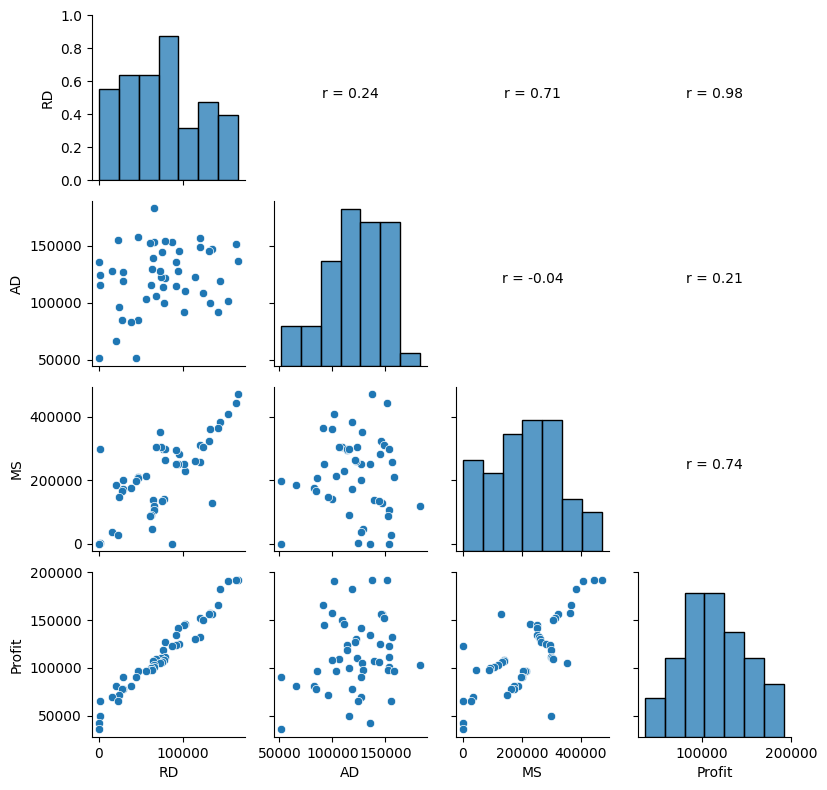

In [49]:
# pair plot and correlation coefficient together
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r),xycoords='axes fraction',xy=(0.5,0.5), ha='center')
    ax.set_axis_off()

g = sns.PairGrid(data,height = 2)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.map_upper(reg_coef)

In [50]:
data.columns

Index(['RD', 'AD', 'MS', 'Profit'], dtype='object')

In [51]:
# Find VIF Values to check how significant these variables are 
# for VIF > 20 : That variable is not significant and we will not nclude that variable in our model

var = ['RD', 'AD', 'MS']
vif = []
for i in var:
    rsq = smf.ols(i+'~'+'+'.join([str(e) for e in var if e!=i]), data=data).fit().rsquared
    vif.append(1/(1-rsq))

vif_df = pd.DataFrame({'variables':var,'VIF':vif}).sort_values('VIF')
#vif_df.sort_values('VIF')
vif_df

# here all the variables are significant

,variables,VIF
1,AD,1.175172
2,MS,2.239957
0,RD,2.377754


In [52]:
# Correlation Coefficient of each column with target (i.e. Price) column.

for i in range(0,4):
    print(f"{data.columns[i]}   : {np.round(data['Profit'].corr(data[data.columns[i]]),2)}")

RD   : 0.98
AD   : 0.21
MS   : 0.74
Profit   : 1.0


## Model building

In [54]:
# We will make model by adding variable in decreasing correlation coefficient 
model1 = smf.ols('Profit~RD',data=data).fit()
model2 = smf.ols('Profit~RD+MS',data=data).fit()
model3 = smf.ols('Profit~RD+MS+AD',data=data).fit()

In [55]:
# Comapre aic,and r_square value of each model
# We need a model with features having : high r square value and less AIC value

models = ['RD','RD+MS','RD+MS+AD']
aic = [model1.aic,model2.aic,model3.aic]
rsquared = [model1.rsquared,model2.rsquared,model3.rsquared]
adj_rsquared = [model1.rsquared_adj,model2.rsquared_adj,model3.rsquared_adj]

pd.DataFrame({'models':models,'aic':aic,'rsquared':rsquared,'adj_rsquared':adj_rsquared})

# model2 with variable RD+MS is good

,models,aic,rsquared,adj_rsquared
0,RD,1021.360015,0.957340,0.956432
1,RD+MS,1018.856480,0.961086,0.959394
2,RD+MS+AD,1020.565297,0.961316,0.958737


#### we will use model2

## Model validation

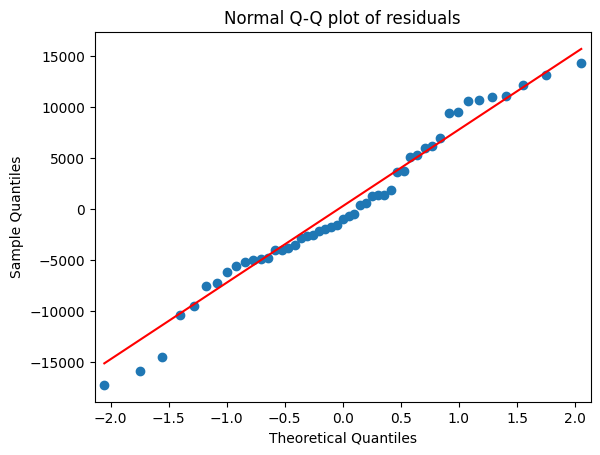

In [56]:
import statsmodels.api as sm
qqplot = sm.qqplot(model2.resid, line='q');
plt.title("Normal Q-Q plot of residuals");

In [57]:
from statsmodels.graphics.regressionplots import influence_plot

model_influence = model2.get_influence() # this method will return two values : cook's 
(c, _)= model_influence.cooks_distance # we don't nedd p values so we placed _ here

Text(0, 0.5, "cook's distance")

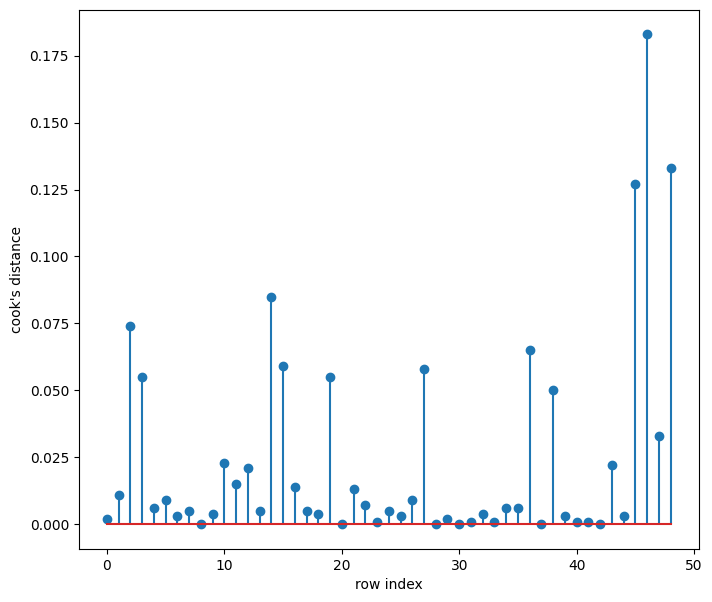

In [58]:
# plot the influencers values using stem plot
fig = plt.subplots(figsize=(8,7))
plt.stem(np.arange(len(data)),np.round(c,3))
plt.xlabel("row index")
plt.ylabel("cook's distance")

In [59]:
np.argmax(c),np.max(c) 

(46, 0.1833755649133877)

In [60]:
data2 = data.drop(data.index[46],axis=0)

## build new model with updated data (data2)

In [61]:
model = smf.ols('Profit~RD+MS',data=data2).fit()
print('rsquared: ',model.rsquared)
print('adjusted rsquared: ', model.rsquared_adj)
print('aic: ',model.aic)

rsquared:  0.9603203117008039
adjusted rsquared:  0.9585567699986174
aic:  997.1027715983952


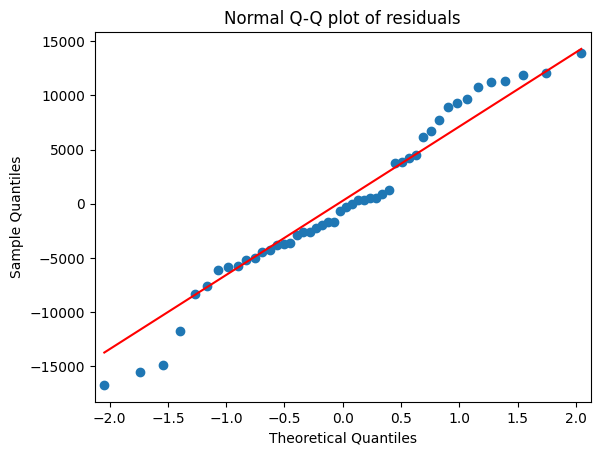

In [62]:
qqplot = sm.qqplot(model.resid, line='q');
plt.title("Normal Q-Q plot of residuals");

In [64]:
model_influence = model.get_influence() # this method will return two values : cook's 
(c, _)= model_influence.cooks_distance # we don't nedd p values so we placed _ here

Text(0, 0.5, "cook's distance")

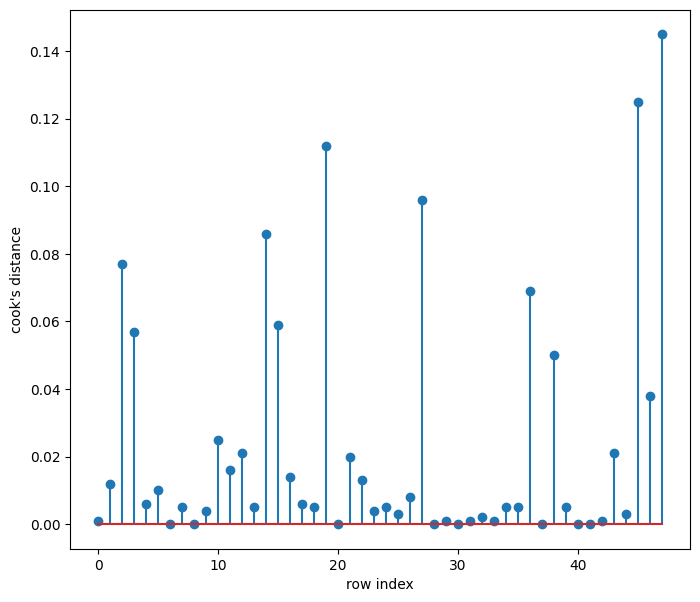

In [65]:
# plot the influencers values using stem plot
fig = plt.subplots(figsize=(8,7))
plt.stem(np.arange(len(data2)),np.round(c,3))
plt.xlabel("row index")
plt.ylabel("cook's distance")

## model is the final model

### Residual Plot for Homoscadasticity

Text(0, 0.5, 'Standardized residual values')

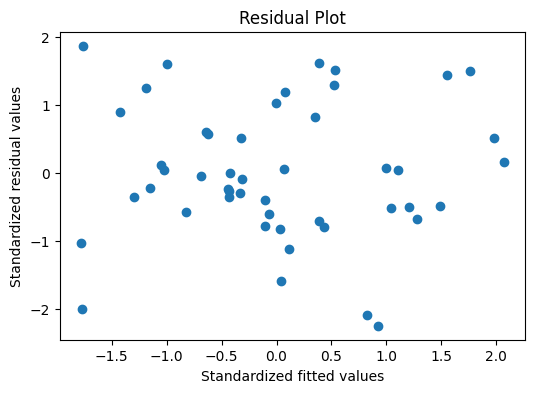

In [66]:
def get_standardized_values(vals):
    return (vals-vals.mean())/vals.std()

plt.figure(figsize=(6,4))
plt.scatter(get_standardized_values(model.fittedvalues), get_standardized_values(model.resid))
plt.title('Residual Plot')
plt.xlabel('Standardized fitted values')
plt.ylabel('Standardized residual values')

### Residual vs Regressor

eval_env: 1


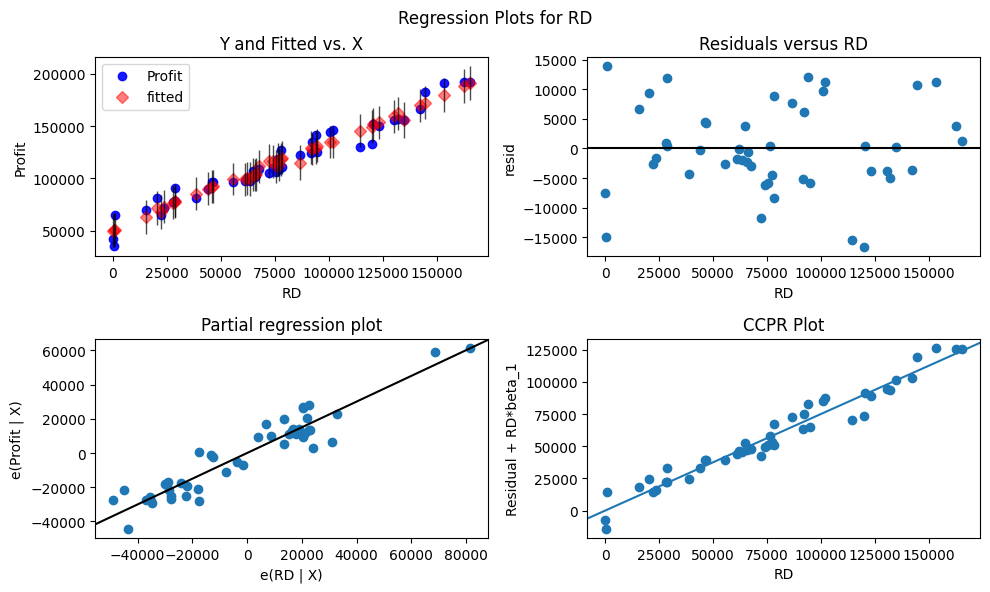

In [68]:
fig = plt.figure(figsize=(10,6))
fig = sm.graphics.plot_regress_exog(model,'RD',fig=fig)

eval_env: 1


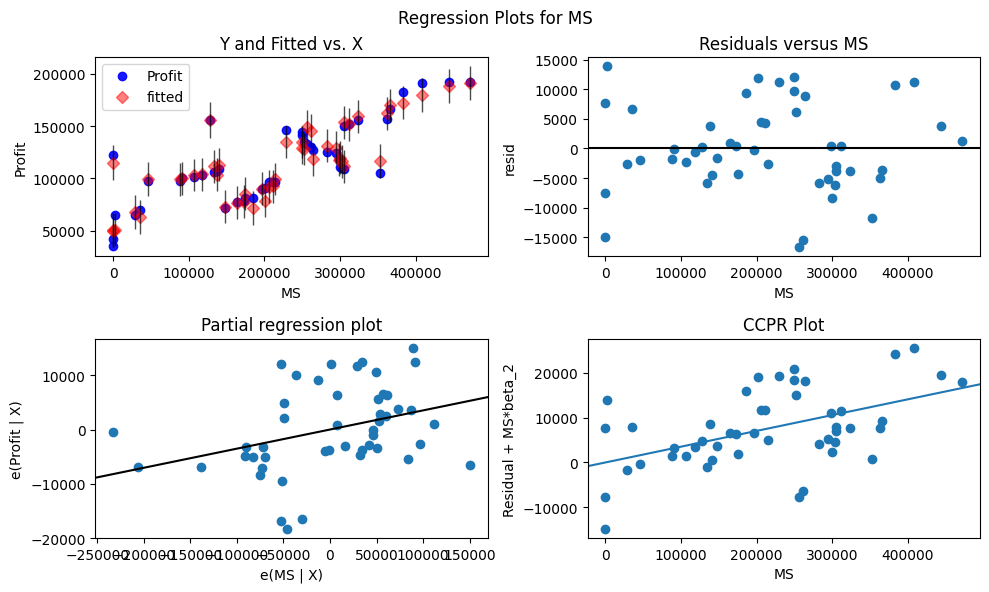

In [69]:
fig = plt.figure(figsize=(10,6))
fig = sm.graphics.plot_regress_exog(model,'MS',fig=fig)

## Prediction

In [72]:
# predicting for new data
new_data = pd.DataFrame({'RD':12568.23,"MS":125638.21},index=["index 1"])
new_data['Profit'] = model.predict(new_data)
new_data

,RD,MS,Profit
index 1,12568.23,125638.21,64044.862696
